In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from __future__ import print_function, division, absolute_import
import imp
import numpy as np
from scipy import constants

import lsst.daf.persistence as daf_persistence
from lsst.sims.photUtils import Bandpass, PhotometricParameters
from lsst.utils import getPackageDir
imp.load_source('calc_refractive_index', '/Users/sullivan/LSST/code/StarFast/calc_refractive_index.py')
from calc_refractive_index import diff_refraction

In [3]:
def look(img, range=None, x_range=None, y_range=None):
    """Simple function to wrap matplotlib and display an image with a colorbar."""
    plt.figure(figsize=(8, 6))
    if range is None:
        range = [np.min(img), np.max(img)]
    img_use = np.clip(img, range[0], range[1])
    if x_range is not None:
        x0 = int(x_range[0])
        x1 = int(x_range[1])
        if x0 < 0:
            img_use = np.roll(img_use, -x0, axis=1)
            x1 -= x0
            x0 = 0
        img_use = img_use[:, x0: x1]
    if y_range is not None:
        y0 = int(y_range[0])
        y1 = int(y_range[1])
        if y0 < 0:
            img_use = np.roll(img_use, -y0, axis=0)
            y1 -= y0
            y0 = 0
        img_use = img_use[y0: y1, :]
    fig_show = plt.imshow(img_use, interpolation='none', origin='lower', cmap=cm.rainbow)
    plt.colorbar(fig_show, orientation='vertical', shrink=1)
#    cbar.set_label('DCR (arcsec)', labelpad=0)
    plt.show()

In [4]:
repository = "/Users/sullivan/LSST/simulations/test6/output_data"
obsid_range = [202, 222, 2]
band_name = "g"

In [5]:
imp.load_source('dcr_1d_correction', '/Users/sullivan/LSST/LSST-DCR/experimental_DCR/python/dcr_1d_correction.py')
from dcr_1d_correction import DcrCorrection

In [6]:
self = DcrCorrection(n_step=5, repository=repository, obsid_range=obsid_range, band_name=band_name)

In [7]:
self.build_matrix()

In [8]:
matrix_squared = np.einsum('ij,ik->jk', self.refract_matrix, self.refract_matrix)

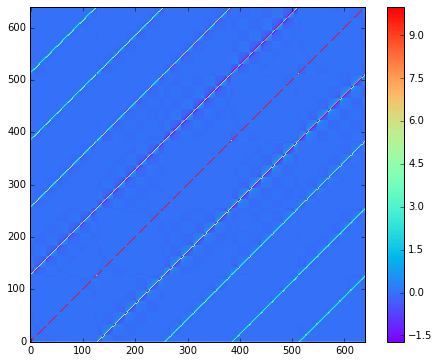

In [11]:
look(matrix_squared)

In [9]:
matrix_squared_inv = np.linalg.inv(matrix_squared)

In [54]:
coefficient_matrix = np.zeros((self.n_step, self.n_step), dtype=np.float64)
matrix_squared_inv2 = np.zeros(matrix_squared.shape)
for _j in range(self.n_step):
    j0 = _j * self.y_size
    j1 = (_j + 1) * self.y_size
    for _i in range(self.n_step):
        i0 = _i * self.y_size
        i1 = (_i + 1) * self.y_size
        coefficient_matrix[_i, _j] = np.max(matrix_squared[i0: i1, j0: j1])
coefficient_matrix /= np.mean(coefficient_matrix)
coefficient_inv = np.linalg.inv(coefficient_matrix)
normalization = 1. / self.n_step**2.0
for _j in range(self.n_step):
    j0 = _j * self.y_size
    j1 = (_j + 1) * self.y_size
    for _i in range(self.n_step):
        i0 = _i * self.y_size
        i1 = (_i + 1) * self.y_size
        matrix_squared_inv2[i0: i1, j0: j1] = ((matrix_squared[i0: i1, j0: j1]).T)

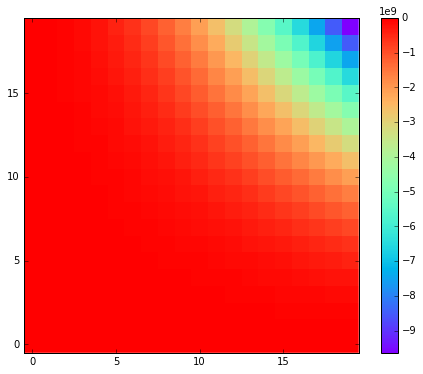

In [10]:
look(matrix_squared_inv, x_range = [0+0,0+20],y_range=[0,20])

In [55]:
if self.use_bandpass:
    bandpass_normalized = self.bandpass.sb / self.bandpass.sb.sum()
else:
    bandpass_normalized = np.ones(self.n_step, dtype=np.float64)
# Matrix version of a linear least squares fit
template = np.zeros((self.y_size, self.x_size, self.n_step))
for _i in range(self.x_size):
    img_vec = np.zeros(self.y_size * self.n_images)
    for s_i, image in enumerate(self.image_arr):
        img_vec[s_i * self.y_size: (s_i + 1) * self.y_size] = image[:, _i] / self.n_images
    # img_vec = np.hstack([image[:, _i] for image in self.image_arr])
    moment_vec = np.einsum('ij,i->j', self.refract_matrix, img_vec)  # transpose of refract_matrix

    template_vec = np.einsum('ij,i->j', matrix_squared_inv2, moment_vec)

    # matrix_squared_inv should be the identity matrix times a scale for each slice
    # template_vec = moment_vec
    for f_i in range(self.n_step):
        template[:, _i, f_i] = template_vec[f_i * self.y_size: (f_i + 1) * self.y_size]
template_arr = [template[:, :, f_i] * bandpass_normalized[f_i] for f_i in range(self.n_step)]

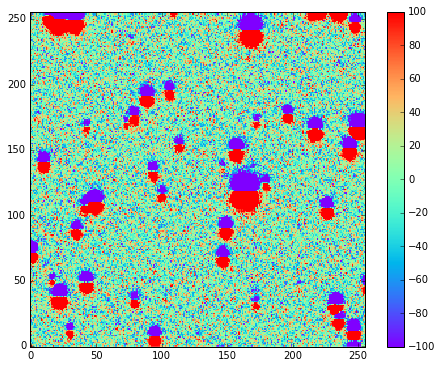

In [67]:
look(template_arr[2]-template_arr[1],x_range=[0,256],y_range=[256,512],range=[-1e2,1e2])

In [71]:
for temp in template_arr:
    print(np.max(temp[356:406,150:200])/self.n_step**2.)

67367.3032737
68988.9232237
69343.6530227
69925.2659049
68967.5678281


In [10]:
coefficient_matrix = np.zeros((self.n_step, self.n_step), dtype=np.float64)
for _j in range(self.n_step):
    j0 = _j * self.y_size
    j1 = (_j + 1) * self.y_size
    for _i in range(self.n_step):
        i0 = _i * self.y_size
        i1 = (_i + 1) * self.y_size
        coefficient_matrix[_i, _j] = np.max(matrix_squared[i0: i1, j0: j1])

In [11]:
coefficient_matrix

array([[ 9.99783157,  6.62358874,  5.82970482,  4.398522  ,  3.76229926],
       [ 6.62358874,  9.99782022,  6.23443114,  6.16743187,  5.03298556],
       [ 5.82970482,  6.23443114,  9.99966678,  6.55554574,  6.81891046],
       [ 4.398522  ,  6.16743187,  6.55554574,  9.99789966,  8.16846226],
       [ 3.76229926,  5.03298556,  6.81891046,  8.16846226,  9.99769425]])

In [12]:
coeff_inv = np.linalg.inv(coefficient_matrix/np.mean(coefficient_matrix))
coeff_inv

array([[ 1.33505881, -0.67880146, -0.46364317,  0.02499465,  0.13511921],
       [-0.67880146,  1.63598245, -0.32403072, -0.64512428,  0.17996028],
       [-0.46364317, -0.32403072,  1.74179245, -0.13064287, -0.74364838],
       [ 0.02499465, -0.64512428, -0.13064287,  2.46342854, -1.60824255],
       [ 0.13511921,  0.17996028, -0.74364838, -1.60824255,  2.35660646]])

In [8]:
test6_obj.build_inverse_squared_matrix()

LinAlgError: Singular matrix

In [ ]:
test6_obj.build_template()

In [159]:
test6_obj.bandpass.sb

array([ 0.28408132,  0.46974225,  0.5176969 ,  0.53733539,  0.20980524])

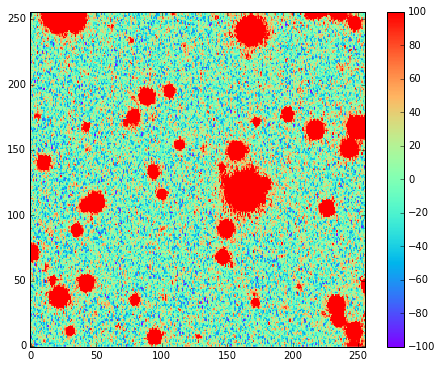

In [157]:
look(test6_obj.template[3],range=[-1e2,1e2],x_range=[0,256],y_range=[256,512])

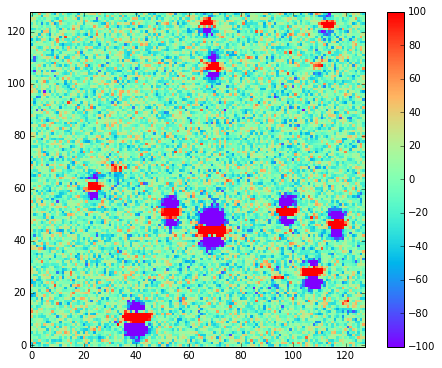

In [86]:
look(test6_obj.image_arr[8]-test6_obj.image_arr[0],range=[-1e2,1e2],x_range=[128,128+128],y_range=[487,487+128])

In [170]:
template = np.zeros((test6_obj.y_size, test6_obj.x_size, test6_obj.n_step))
for _i in range(test6_obj.x_size):
    img_vec = np.zeros(test6_obj.y_size * test6_obj.n_images)
    for s_i, image in enumerate(test6_obj.image_arr):
        img_vec[s_i * test6_obj.y_size: (s_i + 1) * test6_obj.y_size] = image[:, _i]
    # img_vec = np.hstack([image[:, _i] for image in self.image_arr])
    moment_vec = np.einsum('ij,j->i', test6_obj.refract_matrix, img_vec)
    template_vec = np.einsum('ij,i->j', test6_obj.matrix_squared, moment_vec)
    for s_i in range(test6_obj.n_step):
        template[:, _i, s_i] = template_vec[s_i * test6_obj.y_size: (s_i + 1) * test6_obj.y_size]
    # template[:, _i, :] = np.reshape(template_vec.T, (self.y_size, self.n_step))
print("img_vec shape: ", img_vec.shape)
print("moment_vec shape: ", moment_vec.shape)
print("template_vec shape: ", template_vec.shape)
bandpass_normalized = test6_obj.bandpass.sb / test6_obj.bandpass.sb.sum()
test6_obj.template = [template[:, :, f_i] * bandpass_normalized[f_i] for f_i in range(test6_obj.n_step)]

img_vec shape:  (5120,)
moment_vec shape:  (4096,)
template_vec shape:  (4096,)


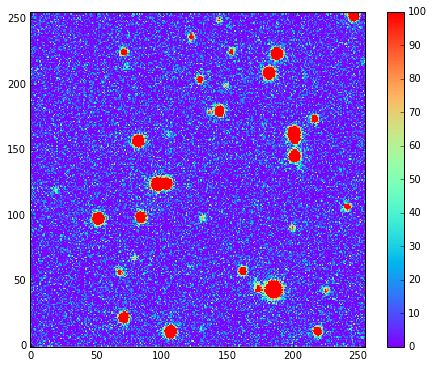

In [64]:
look(test6_obj.image_arr[4],range=[0,1e2],x_range=[0,256],y_range=[0,256])

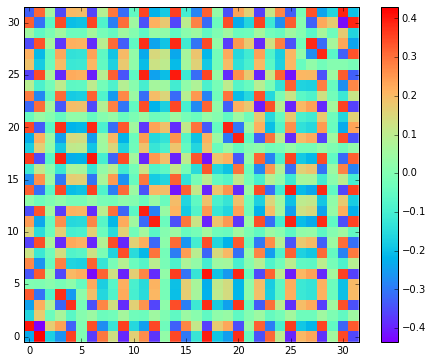

In [395]:
x0 = 1024
x1 = x0 + 32
y0 = 0
y1 = y0 + 32
look(np.linalg.inv(matrix_squared[y0:y1,x0:x1]))

In [396]:
mat_test = matrix_squared[0:256,0:256]
mat_test_inv = np.linalg.inv(mat_test)

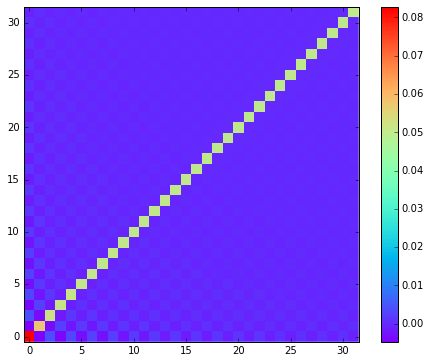

In [430]:
look(mat_test_inv,x_range=[0,32],y_range=[0,32])

In [382]:
refract_matrix = test6_obj.refract_matrix
matrix_squared = np.einsum('ji,ki->jk', refract_matrix, refract_matrix)
matrix_squared_inv = np.linalg.inv(matrix_squared)
# for _j in range(test6_obj.n_step):
#     for _i in range(test6_obj.n_step):
#         j0 = _j * test6_obj.y_size
#         j1 = (_j + 1) * test6_obj.y_size
#         i0 = _i * test6_obj.y_size
#         i1 = (_i + 1) * test6_obj.y_size
#         sub_matrix = matrix_squared[j0:j1, i0:i1]
#         # large array, so perform operation in place
#         matrix_squared[j0:j1, i0:i1] = np.linalg.inv(sub_matrix)
#         matrix_squared[j0, i0:i1] = 0.
#         matrix_squared[j1 - 1, i0:i1] = 0.
#         matrix_squared[j0:j1, i0] = 0.
#         matrix_squared[j0:j1, i1 - 1] = 0.

In [28]:
mat_test2=np.zeros((128,128),dtype=np.float64)
for _i in range(4):
    for _j in range(4):
        mat_test2[_j * 32:(_j+1)*32,_i*32:(_i+1)*32] = np.eye(32) * (1 - np.random.uniform()/4)

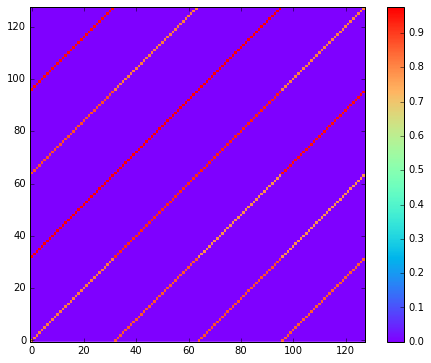

In [424]:
look(mat_test2)

In [425]:
mat_test2_inv = np.linalg.inv(mat_test2)

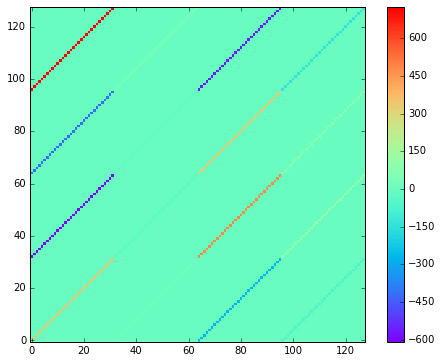

In [428]:
look(mat_test2_inv)

In [32]:
np.sum(mat_test2, axis=0)

array([ 3.36469423,  3.36469423,  3.36469423,  3.36469423,  3.36469423,
        3.36469423,  3.36469423,  3.36469423,  3.36469423,  3.36469423,
        3.36469423,  3.36469423,  3.36469423,  3.36469423,  3.36469423,
        3.36469423,  3.36469423,  3.36469423,  3.36469423,  3.36469423,
        3.36469423,  3.36469423,  3.36469423,  3.36469423,  3.36469423,
        3.36469423,  3.36469423,  3.36469423,  3.36469423,  3.36469423,
        3.36469423,  3.36469423,  3.78828754,  3.78828754,  3.78828754,
        3.78828754,  3.78828754,  3.78828754,  3.78828754,  3.78828754,
        3.78828754,  3.78828754,  3.78828754,  3.78828754,  3.78828754,
        3.78828754,  3.78828754,  3.78828754,  3.78828754,  3.78828754,
        3.78828754,  3.78828754,  3.78828754,  3.78828754,  3.78828754,
        3.78828754,  3.78828754,  3.78828754,  3.78828754,  3.78828754,
        3.78828754,  3.78828754,  3.78828754,  3.78828754,  3.5003362 ,
        3.5003362 ,  3.5003362 ,  3.5003362 ,  3.5003362 ,  3.50

In [58]:
(np.ones((5,4))+2)**2

array([[ 9.,  9.,  9.,  9.],
       [ 9.,  9.,  9.,  9.],
       [ 9.,  9.,  9.,  9.],
       [ 9.,  9.,  9.,  9.],
       [ 9.,  9.,  9.,  9.]])

In [ ]:
a = np.arange

In [40]:
b = np.power(a,2)

In [42]:
a

array([], dtype=int64)